# fMRI-EGG Processing Pipeline

Process EGG data recorded concurrently with fMRI. This example
demonstrates scanner trigger parsing, per-volume phase extraction,
and transient volume removal using `gastropy.neuro.fmri`.

In [1]:
import matplotlib.pyplot as plt

import gastropy as gp
from gastropy.neuro.fmri import apply_volume_cuts, create_volume_windows, phase_per_volume

plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

## Load fMRI-EGG Data

The fMRI-EGG sample data includes scanner trigger times and the
repetition time (TR).

In [2]:
fmri = gp.load_fmri_egg(session="0001")

print(f"Signal shape:    {fmri['signal'].shape}")
print(f"Sampling rate:   {fmri['sfreq']} Hz")
print(f"TR:              {fmri['tr']} s")
print(f"Trigger times:   {len(fmri['trigger_times'])} volumes")
print(f"Duration:        {fmri['duration_s']:.0f} s ({fmri['duration_s'] / 60:.1f} min)")

Signal shape:    (8, 7795)
Sampling rate:   10.0 Hz
TR:              1.856 s
Trigger times:   420 volumes
Duration:        780 s (13.0 min)


## Select Channel and Extract Phase

In [3]:
best_idx, peak_freq, _, _ = gp.select_best_channel(fmri["signal"], fmri["sfreq"])
print(f"Best channel: {list(fmri['ch_names'])[best_idx]} ({peak_freq * 60:.1f} cpm)")

# Filter and extract phase
filtered, _ = gp.apply_bandpass(
    fmri["signal"][best_idx], fmri["sfreq"], low_hz=gp.NORMOGASTRIA.f_lo, high_hz=gp.NORMOGASTRIA.f_hi
)
phase, analytic = gp.instantaneous_phase(filtered)

Best channel: EGG8 (2.4 cpm)


## Per-Volume Phase Extraction

Map each fMRI volume to a mean gastric phase value by averaging
the complex analytic signal within each volume's time window.

In [4]:
n_volumes = len(fmri["trigger_times"])
windows = create_volume_windows(fmri["trigger_times"], fmri["tr"], n_volumes)
vol_phase = phase_per_volume(analytic, windows)

print(f"Volume phases: {vol_phase.shape} (one phase per volume)")
print(f"Phase range: [{vol_phase.min():.2f}, {vol_phase.max():.2f}] rad")

Volume phases: (420,) (one phase per volume)
Phase range: [-3.13, 3.13] rad


## Visualize and Trim Transients

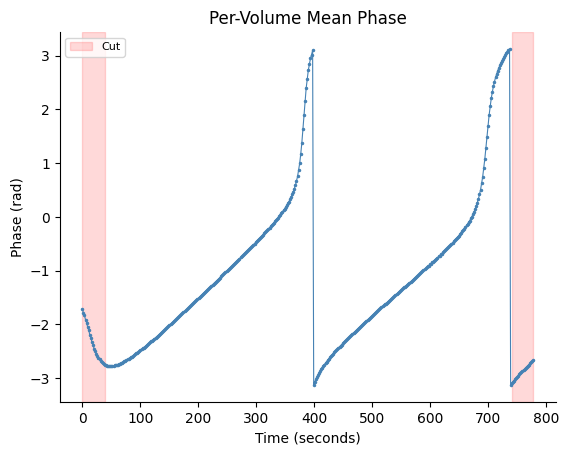

Before cut: 420 volumes
After cut:  378 volumes


In [5]:
# Plot with cut regions
fig, ax = gp.plot_volume_phase(vol_phase, tr=fmri["tr"], cut_start=21, cut_end=21)
plt.show()

# Apply cuts
trimmed = apply_volume_cuts(vol_phase, begin_cut=21, end_cut=21)
print(f"Before cut: {len(vol_phase)} volumes")
print(f"After cut:  {len(trimmed)} volumes")

## Comprehensive Figure with Volume Phase

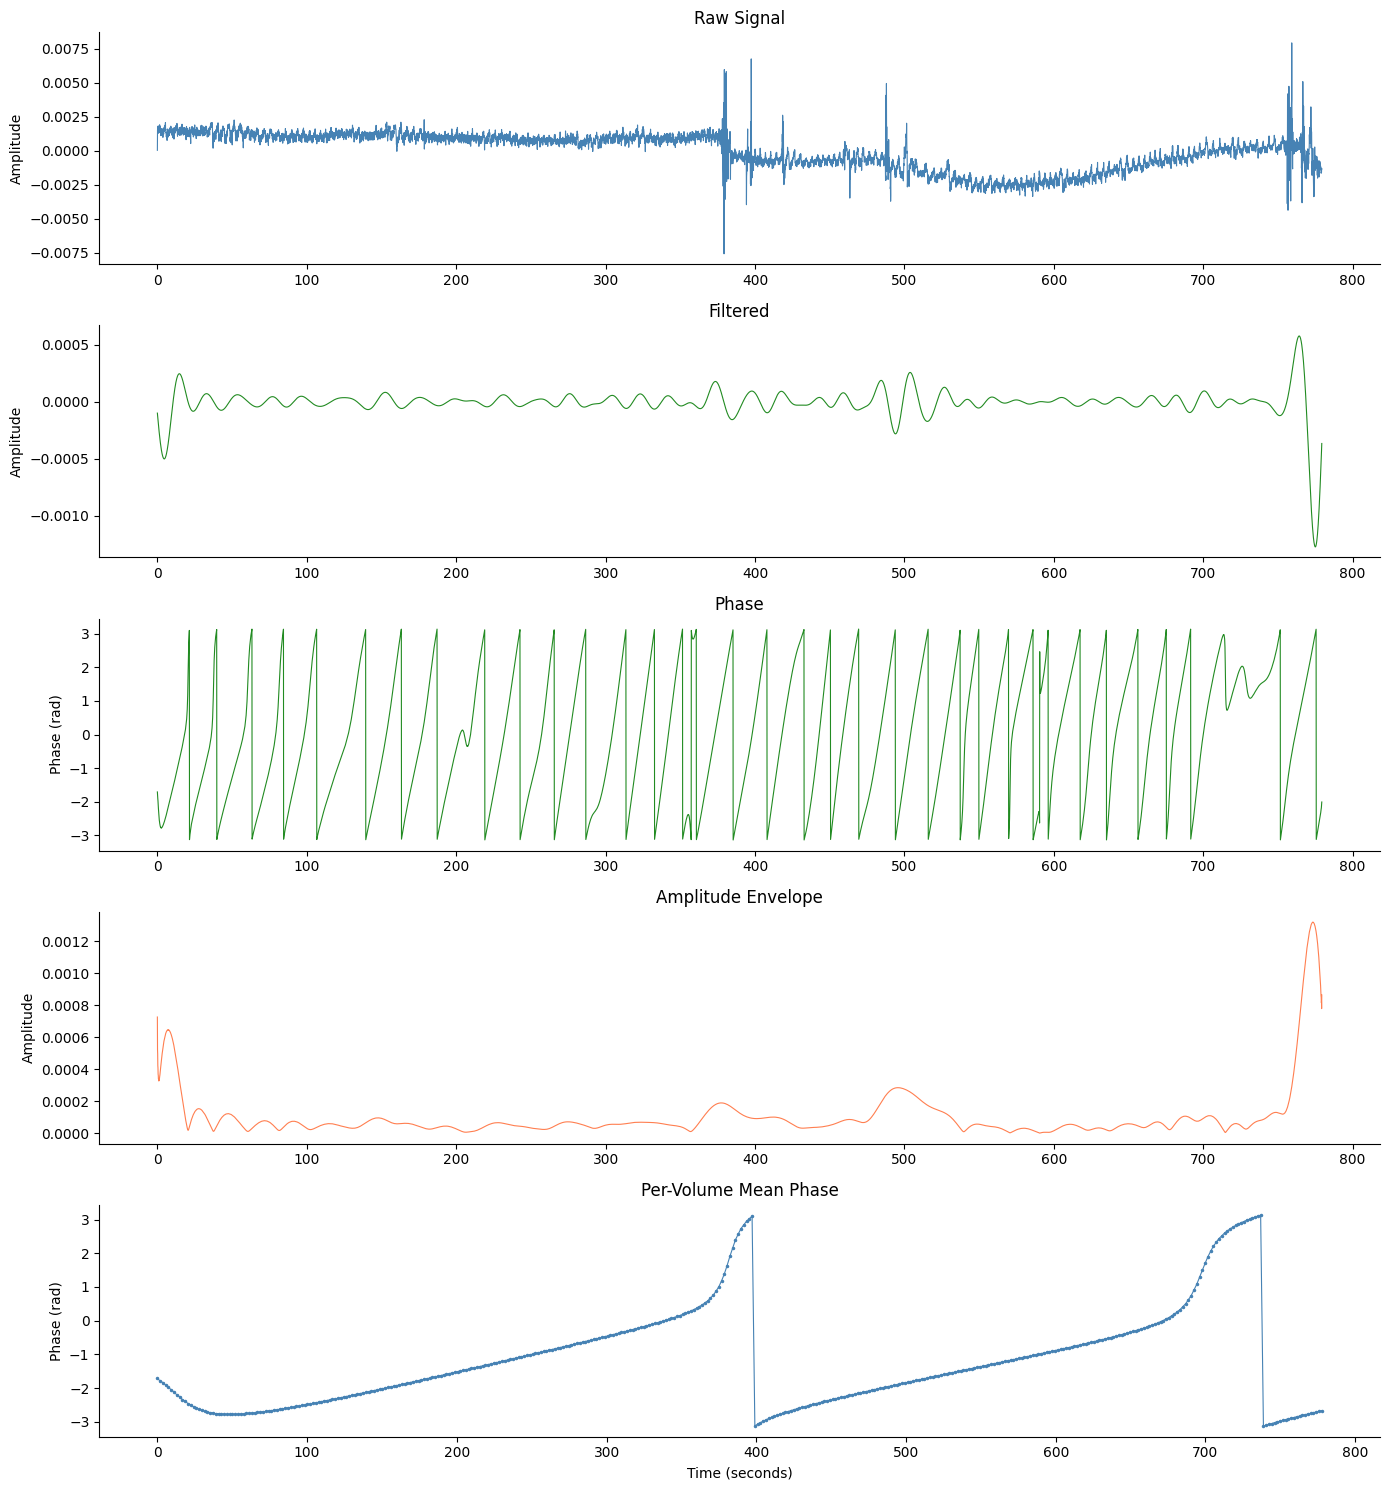

In [6]:
# Run egg_process for the overview panels
signals_df, info = gp.egg_process(fmri["signal"][best_idx], fmri["sfreq"])

fig, axes = gp.plot_egg_comprehensive(
    signals_df,
    fmri["sfreq"],
    phase_per_vol=vol_phase,
    tr=fmri["tr"],
)
plt.show()

**See also:** [Per-Volume Phase Plot](plot_volume_phase.ipynb),
[Comprehensive Figure](plot_egg_comprehensive.ipynb)